<h2 style="color: #33ccff;">Designing Experiments for Statistical Testing</h2>

This notebook is supplemental to the paper published at [arXiv](https://arxiv.org/abs/2405.18077) and focuses on the part of the statistical evaluation of experimental results.

In the domain of ML, researchers often want to compare the performance of an algorithm to other algorithms. Since this is not possible through theoretical analysis, experiments are conducted that deliver a metric of interest, such as accuracy or f1 score. Then those metrics are compared between algorithms. To allow for meaningfull analysis of those metrics, simple comparison of mean and variance values over the algorithm metrics is not sufficient. Statistical tests offer a method of testing whether one algorithm is performing better than another with a measurable level of certainty. Here we go through a mock-example of how this can be achieved.

<h3 style="color: #33ccff;">1. Hypothesis Design</h3>

First, we need to design the hypotheses, which we want to test. They consist of the null hypothesis, stating no effect, and the alternative hypothesis, stating a (desired) effect.
* H0: Algorithm A and B have the same mean performance.
* HA: Algorithm A has a better mean performance than algorithm B.

<h3 style="color: #33ccff;">2. Power Analysis (Sample size calculation)</h3>

Determining the number of samples needed in advance is critical for ensuring a study has adequate power to detect a statistically significant difference between two algorithms if one exists. This process is known as power analysis, and it involves several key components: the effect size, the desired statistical power, the significance level, and the variability in the data.

1. Defining the Effect Size (must)

Effect size quantifies the magnitude of a difference or relationship in statistical analysis, with values varying significantly across different fields and contexts. Common measures include:

* Cohen’s d for mean differences: small (0.20), medium (0.50), and large (0.80).
* Pearson's r for correlations: small (0.10), medium (0.30), and large (0.50).
* Odds Ratio (OR) and Risk Ratio (RR) in epidemiological studies.
* Eta squared (η²) and Omega squared (ω²) in ANOVA: small (0.01 for η²), medium (0.06 for η²), and large (0.14 for η²).

2. Setting the Desired Power (must)

Power is the probability that a test correctly rejects the null hypothesis when it is false (i.e., detects an effect if there is one). A common target is 0.80, meaning there's an 80% chance of detecting an effect if one truly exists.

3. Choosing the Significance Level (alpha) (must)

The significance level (alpha) is the threshold for rejecting the null hypothesis. It’s typically set at 0.05, which means there’s a 5% chance of rejecting the null hypothesis when it's actually true (Type I error).

4. Estimating Variability (optional)

Existing data can be used to estimate the variability (standard deviation) in the performance metrics. The greater the variability, the larger the sample size needed to detect a given effect size.

5. Power Analysis Tools

* Using Software like G*Power or R: These tools offer comprehensive options for power analysis.
* Python Libraries: Libraries like statsmodels can be used for power calculations.

Below we use statsmodels to compute a required sample size.

In [21]:
import statsmodels.stats.power as smp

# Parameters
effect_size = 0.5  # Cohen's d
alpha = 0.05       # Significance level
power = 0.80       # Desired power
ratio = 1          # Ratio of sample sizes in both groups (1 if equal size)

# Calculate sample size
sample_size = smp.TTestIndPower().solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)
print(f"Required sample size per group: {sample_size:.2f}")


Required sample size per group: 63.77


<h3 style="color: #33ccff;">4. Experiment Execution</h3>

Here we randomly sample values for A and B from normal distributions to represent data from experiments.

In [13]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(42)

# Parameters for the normal distributions
# Algorithm A: mean = 100, standard deviation = 10
# Algorithm B: mean = 95, standard deviation = 10
mean_A = 100
std_A = 10
mean_B = 90
std_B = 10

# Generate random samples for each algorithm
samples = 100
samples_A = np.random.normal(mean_A, std_A, samples)
samples_B = np.random.normal(mean_B, std_B, samples)

# Print the first few samples to check
print("First few samples from Algorithm A:", samples_A[:5])
print("First few samples from Algorithm B:", samples_B[:5])


First few samples from Algorithm A: [104.96714153  98.61735699 106.47688538 115.23029856  97.65846625]
First few samples from Algorithm B: [75.84629258 85.79354677 86.57285483 81.97722731 88.38714288]


<h3 style="color: #33ccff;">5. Post-experimental Tests prior to Statistical Testing</h3>

<h3 style="color: #33ccff;">5a. Checking the Posterior Cohen's d</h3>

After experiment execution, we can compute the actual value of Cohen's d and compare it to our initial estimate.

In [6]:
import numpy as np
from scipy import stats
import statsmodels.stats.power as smp

# Calculate Cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)


# Calculate effect size
d = cohen_d(samples_A, samples_B)

# Power analysis
power_analysis = smp.TTestIndPower()
power = power_analysis.solve_power(effect_size=d, nobs1=samples, ratio=1.0, alpha=0.05)

print(f"Effect Size (Cohen's d): {d:.3f}")
print(f"Power of the test: {power:.3f}")


Effect Size (Cohen's d): 0.531
Power of the test: 0.962


<h3 style="color: #33ccff;">5b. Testing for Normality</h3>

The [Shapiro-Wilk](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) test is a common test for normality that evaluates whether a dataset is likely to have been drawn from a Gaussian distribution. A high p-value (typically > 0.05) suggests that the null hypothesis of normality cannot be rejected. Hence, we assume normality for high p-values.

In [7]:
# Perform the Shapiro-Wilk test for normality
shapiro_test_A = stats.shapiro(samples_A)
shapiro_test_B = stats.shapiro(samples_B)

print("Shapiro-Wilk Test for Algorithm A:")
print(f"Statistic: {shapiro_test_A[0]:.4f}, P-value: {shapiro_test_A[1]:.4f}")

print("\nShapiro-Wilk Test for Algorithm B:")
print(f"Statistic: {shapiro_test_B[0]:.4f}, P-value: {shapiro_test_B[1]:.4f}")


Shapiro-Wilk Test for Algorithm A:
Statistic: 0.9899, P-value: 0.6551

Shapiro-Wilk Test for Algorithm B:
Statistic: 0.9775, P-value: 0.0853


[Quantile-Quantile (Q-Q) plots](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html) are visual methods for assessing if data come from a particular distribution. They plot the quantiles of the data against the quantiles of the theoretical distribution.
* Straight Line: In a Q-Q plot, the quantiles of the data are plotted against the quantiles of a specified theoretical distribution. For data that follows a normal distribution, the points should ideally lie on a straight diagonal line that typically runs from the bottom left to the top right of the plot.
* S-shaped Curve: If the plot shows an S-shaped curve, this indicates that the data has heavier tails than the normal distribution. This means there are more extreme values (both low and high) than what would be expected in a normal distribution.
* Left-Skewed Data: If the points curve upward and then level off, it suggests that the data are left-skewed compared to the normal distribution.
* Right-Skewed Data: If the points curve downward before leveling off, it indicates right-skewed data.


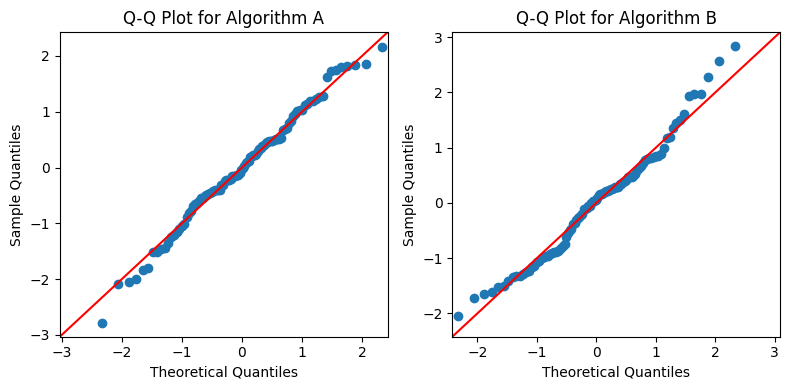

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Generate Q-Q plot for Algorithm A
sm.qqplot(samples_A, line='45', fit=True, ax=ax1)
ax1.set_title('Q-Q Plot for Algorithm A')

# Generate Q-Q plot for Algorithm B
sm.qqplot(samples_B, line='45', fit=True, ax=ax2)
ax2.set_title('Q-Q Plot for Algorithm B')

plt.tight_layout()
plt.show()


<h3 style="color: #33ccff;">5c. Testing for Homogeneity of Variances (equal variances)</h3>

Test the null hypothesis that all input samples are from populations with equal variances.
* [Bartlett’s test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html#scipy.stats.bartlett) tests the null hypothesis that all input samples are from populations with equal variances.
* For samples from significantly non-normal populations, [Levene’s test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html) is more robust and the preffered choice.


In [18]:
from scipy import stats

# Conduct Bartlett's test for equal variances
stat, p_value = stats.bartlett(samples_A, samples_B)

print(f"Bartlett's test statistic: {stat:.3f}")
print(f"P-value: {p_value:.3f}")

alpha = 0.05
if p_value <= alpha:
    print("Reject the null hypothesis of equal variances: The variances are not equal")
else:
    print("Fail to reject the null hypothesis of equal variances: Variances might be equal ")

Bartlett's test statistic: 0.235
P-value: 0.628
Fail to reject the null hypothesis of equal variances: Variances might be equal 


In [17]:
from scipy import stats

# Conduct Levene's test for equal variances
stat, p_value = stats.levene(samples_A, samples_B)

print(f"Levene's test statistic: {stat:.3f}")
print(f"P-value: {p_value:.3f}")

alpha = 0.05
if p_value <= alpha:
    print("Reject the null hypothesis of equal variances: The variances are not equal")
else:
    print("Fail to reject the null hypothesis of equal variances: Variances might be equal ")

Levene's test statistic: 0.180
P-value: 0.672
Fail to reject the null hypothesis of equal variances: Variances might be equal 


<h3 style="color: #33ccff;">6. Hypothesis Testing</h3>

To test the null hypothesis that the mean performance of Algorithm A is equal to that of Algorithm B, we use statistical tests.
The choice of test depends on the nature of the data and its distribution. We assume that experiments are performed under the same conditions, so that paired tests can be used.

| Distribution   | Variances   | Appropriate Test                        |
|----------------|-------------|-----------------------------------------|
| **Normal**     | Equal       | Paired t-test                           |
| **Normal**     | Unequal     | Paired t-test with Welch's correction   |
| **Not Normal** | Any         | Wilcoxon signed-rank test               |
| **Mixed**      | Any         | Mann-Whitney U test, Kolmogorov-Smirnov test |


<h3 style="color: #33ccff;">6a. Unequal Variances</h3>

This can be done assuming unequal variances (Welch's t-test), which does not require the assumption of equal variances between the two groups. Here we use the scipy.stats [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) in Python to perform this test.

In [39]:
from scipy import stats

# Perform a two-sample t-test (Welch's t-test)
t_stat, p_value = stats.ttest_ind(samples_A, samples_B, equal_var=False, alternative='greater')

# Print the results of the t-test
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Decision on the null hypothesis based on p-value (alpha = 0.05)
alpha = 0.05
if p_value <= alpha:
    print("Reject the null hypothesis: there is significant evidence that Algorithm A performs better than Algorithm B.")
else:
    print("Fail to reject the null hypothesis: there is not enough evidence to conclude that Algorithm A performs better than Algorithm B.")


T-statistic: -1.1652
P-value: 0.8780
Fail to reject the null hypothesis: there is not enough evidence to conclude that Algorithm A performs better than Algorithm B.


<h3 style="color: #33ccff;">6b. Equal Variances</h3>

When testing the hypothesis that two groups have different means and the variances of the distributions are equal (also known as homogeneity of variances), one would typically use the Student's t-test. This version of the t-test assumes that both groups being compared are drawn from populations with equal variances. This assumption allows for a more straightforward calculation of the standard error of the difference between means, which is crucial for the t-statistic calculation. Here we use the [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) function.

In [10]:
# Perform the Student's t-test for equal variances
t_stat, p_value = stats.ttest_ind(samples_A, samples_B, equal_var=True)

# Print the t-statistic and the p-value
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value <= alpha:
    print("Reject the null hypothesis: there is significant evidence that Algorithm A performs better than Algorithm B.")
else:
    print("Fail to reject the null hypothesis: there is not enough evidence to conclude that Algorithm A performs better than Algorithm B.")

T-statistic: 3.753
P-value: 0.0002
Reject the null hypothesis: there is significant evidence that Algorithm A performs better than Algorithm B.


<h3 style="color: #33ccff;">7. Final Remarks</h3>

ML experiments can become time and resource intensive. Given that often only small effect sizes are to be expected, approaches are needed to reduce computational cost, whilst maintaining the needed sample size for statistical testing. We propose, that experiments are carried out without the needed sample size in a first iteration and only the best performing candidates are put through a full sampling process.

The full sampling process shall be the same for all candidates.

Presenting the results:
* Testing of null hypothesis
* Quantified effect size, e.g., Cohen's d